In [60]:
import pandas as pd
import numpy as np
import random
from numba import jit, cuda
@jit(target_backend='cuda')
data=pd.read_csv("FAOLEX_ALL.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

SyntaxError: invalid syntax (2607396393.py, line 6)

In [4]:
# remve repealed legislation
data["Repealed"].fillna(value = "N", inplace=True)
data["Repealed"] = pd.Categorical(data["Repealed"])
data=data[data["Repealed"]=="N"]


In [5]:
#data = data[data["Type of text"]=="Legislation"]

In [6]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1




In [7]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])




In [8]:
# Ignore
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [9]:
print(keywords[15])
print(stemmed_words[15])


['maritime zone', ' EEZ-Exclusive Economic Zone', ' continental shelf']
['maritime zon', ' eez-exclusive economic zon', ' continental shelf']


# Top2vec topic model

In [10]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
#model = Top2Vec(keywords,embedding_model="doc2vec")
model = Top2Vec.load("C:/Users/Jacob pc/PycharmProjects/Fagprojekt/top2vec_model2")

C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

In [11]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1467, 1179, 1178, ...,   22,   21,   19], dtype=int64)

In [12]:
model.get_num_topics()

1052

In [13]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [14]:
#save the model
#model.save("top2vec model")

#to load the data
#model = Top2Vec.load("top2vec model")

In [15]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 71116, Score: 0.9755139350891113
-----------
land tenure land valuation taxes 
-----------

Document: 29289, Score: 0.9700651168823242
-----------
land tenure public land taxes  land valuation
-----------

Document: 26087, Score: 0.9660254716873169
-----------
land tenure land valuation
-----------

Document: 26128, Score: 0.9612650275230408
-----------
land valuation legal proceedings/administrative proceedings
-----------

Document: 36278, Score: 0.959018886089325
-----------
institution land valuation
-----------

Document: 35802, Score: 0.9583790302276611
-----------
taxes  land valuation
-----------

Document: 90932, Score: 0.9580174684524536
-----------
cadastre/land registration land tenure land valuation
-----------

Document: 25987, Score: 0.9569132924079895
-----------
land tenure land valuation
-----------

Document: 43041, Score: 0.9534005522727966
-----------
monitoring land valuation cadastre/land registration
-----------

Document: 5132, Score: 0.95245122909545

In [16]:
# Check documents
data.iloc[370]

Record Id                                                     LEX-FAOC001586
Record URL                 http://www.fao.org/faolex/results/details/en/c...
Document URL                     https://faolex.fao.org/docs/pdf/tun1586.pdf
Title                      Arrêté du Ministre de l'agriculture du 26 févr...
Original title                                                           NaN
Date of original text                                             26-02-1982
Last amended date                                                        NaN
Available website                                                        NaN
Language of document                                                  French
Country/Territory                                                    Tunisia
Regional organizations                                                   NaN
Territorial subdivision                                                  NaN
Type of text                                                      Regulation

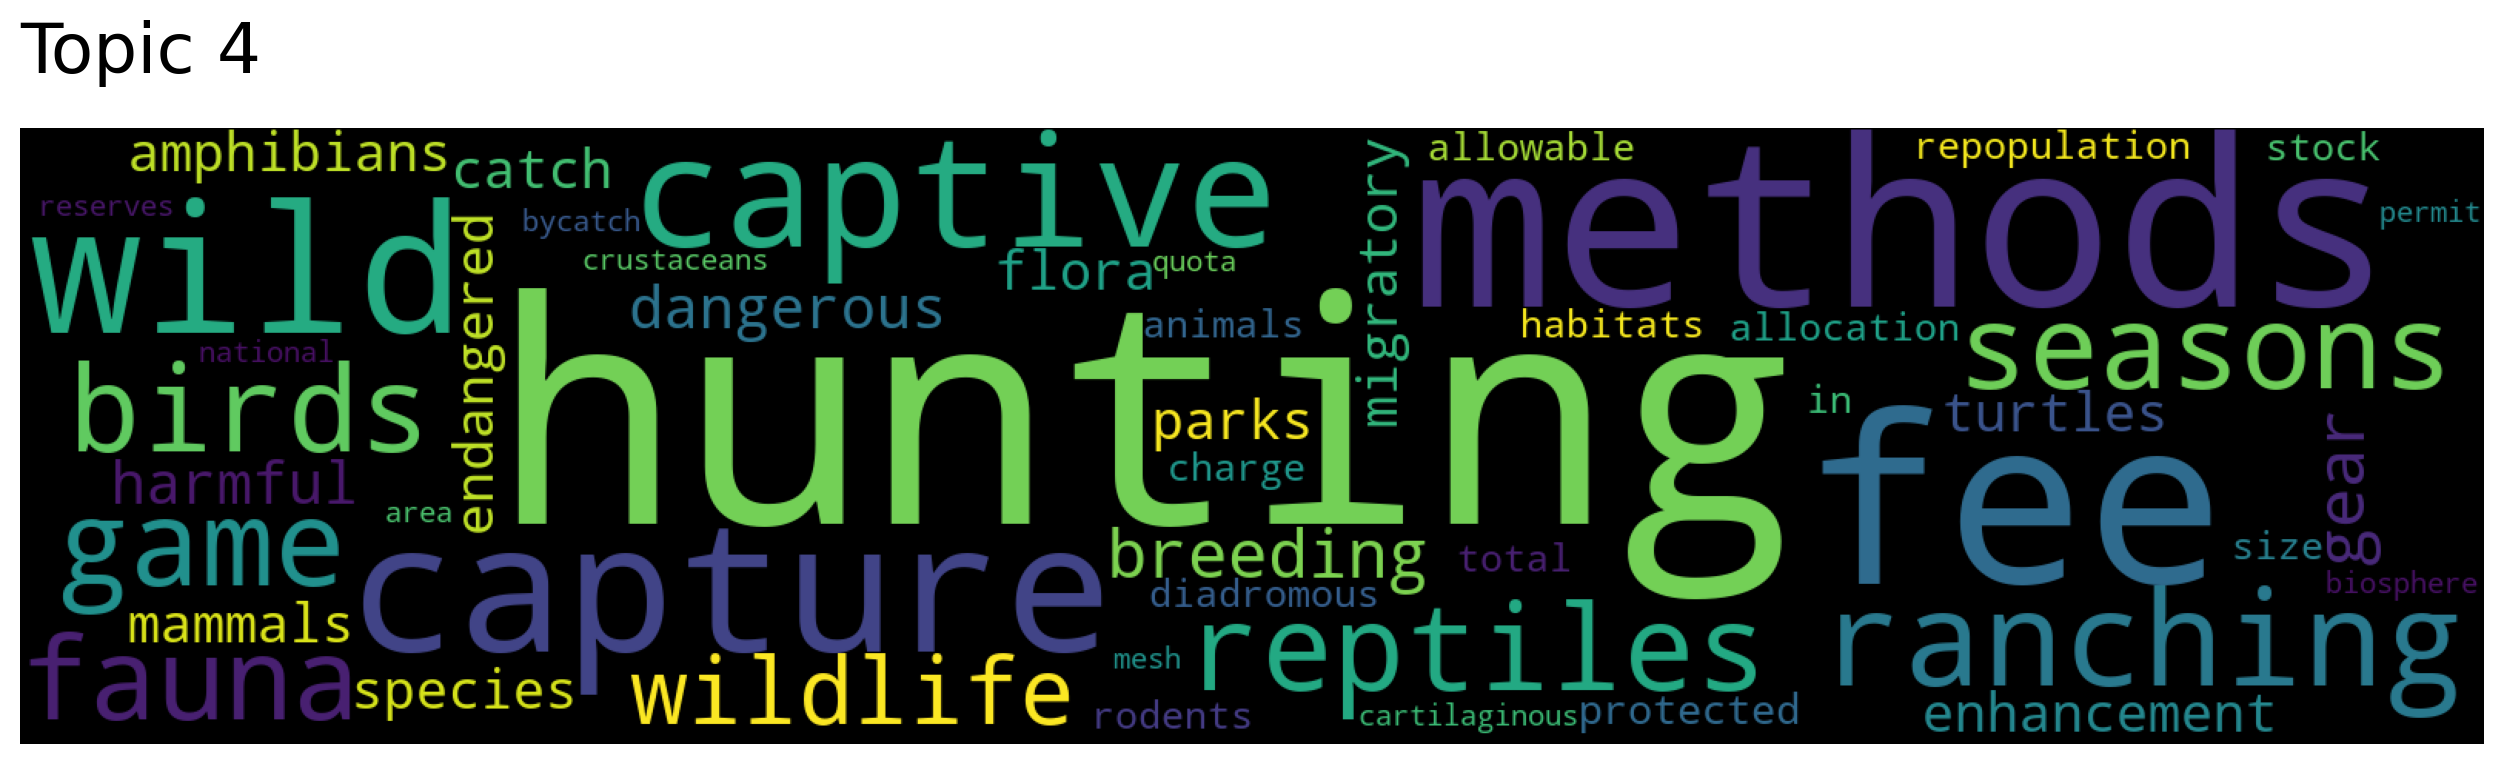

In [17]:
model.generate_topic_wordcloud(4,reduced=False)

In [18]:
# Look up topics corresponding to a keyword
#topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
#print(topic_words)
#print(topic_nums)
#print(topic_scores)

#Topic reduction

In [19]:
# Reduce number of topics to n
n=75
topic_mapping = model.hierarchical_topic_reduction(num_topics=n)


In [20]:
# Reduce number of countries
reduced=False

In [21]:
model.get_num_topics(reduced=True)
#print(model.topic_words_reduced)

75

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [22]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [23]:
#View all countries
#set(country_new)

In [24]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1


In [25]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num],reduced=reduced)
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [26]:

 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

#Standardisering
#for i in range(len(countries)):
 #   country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 


In [27]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

(257, 257)

In [28]:
#Remove small islands

for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country Network

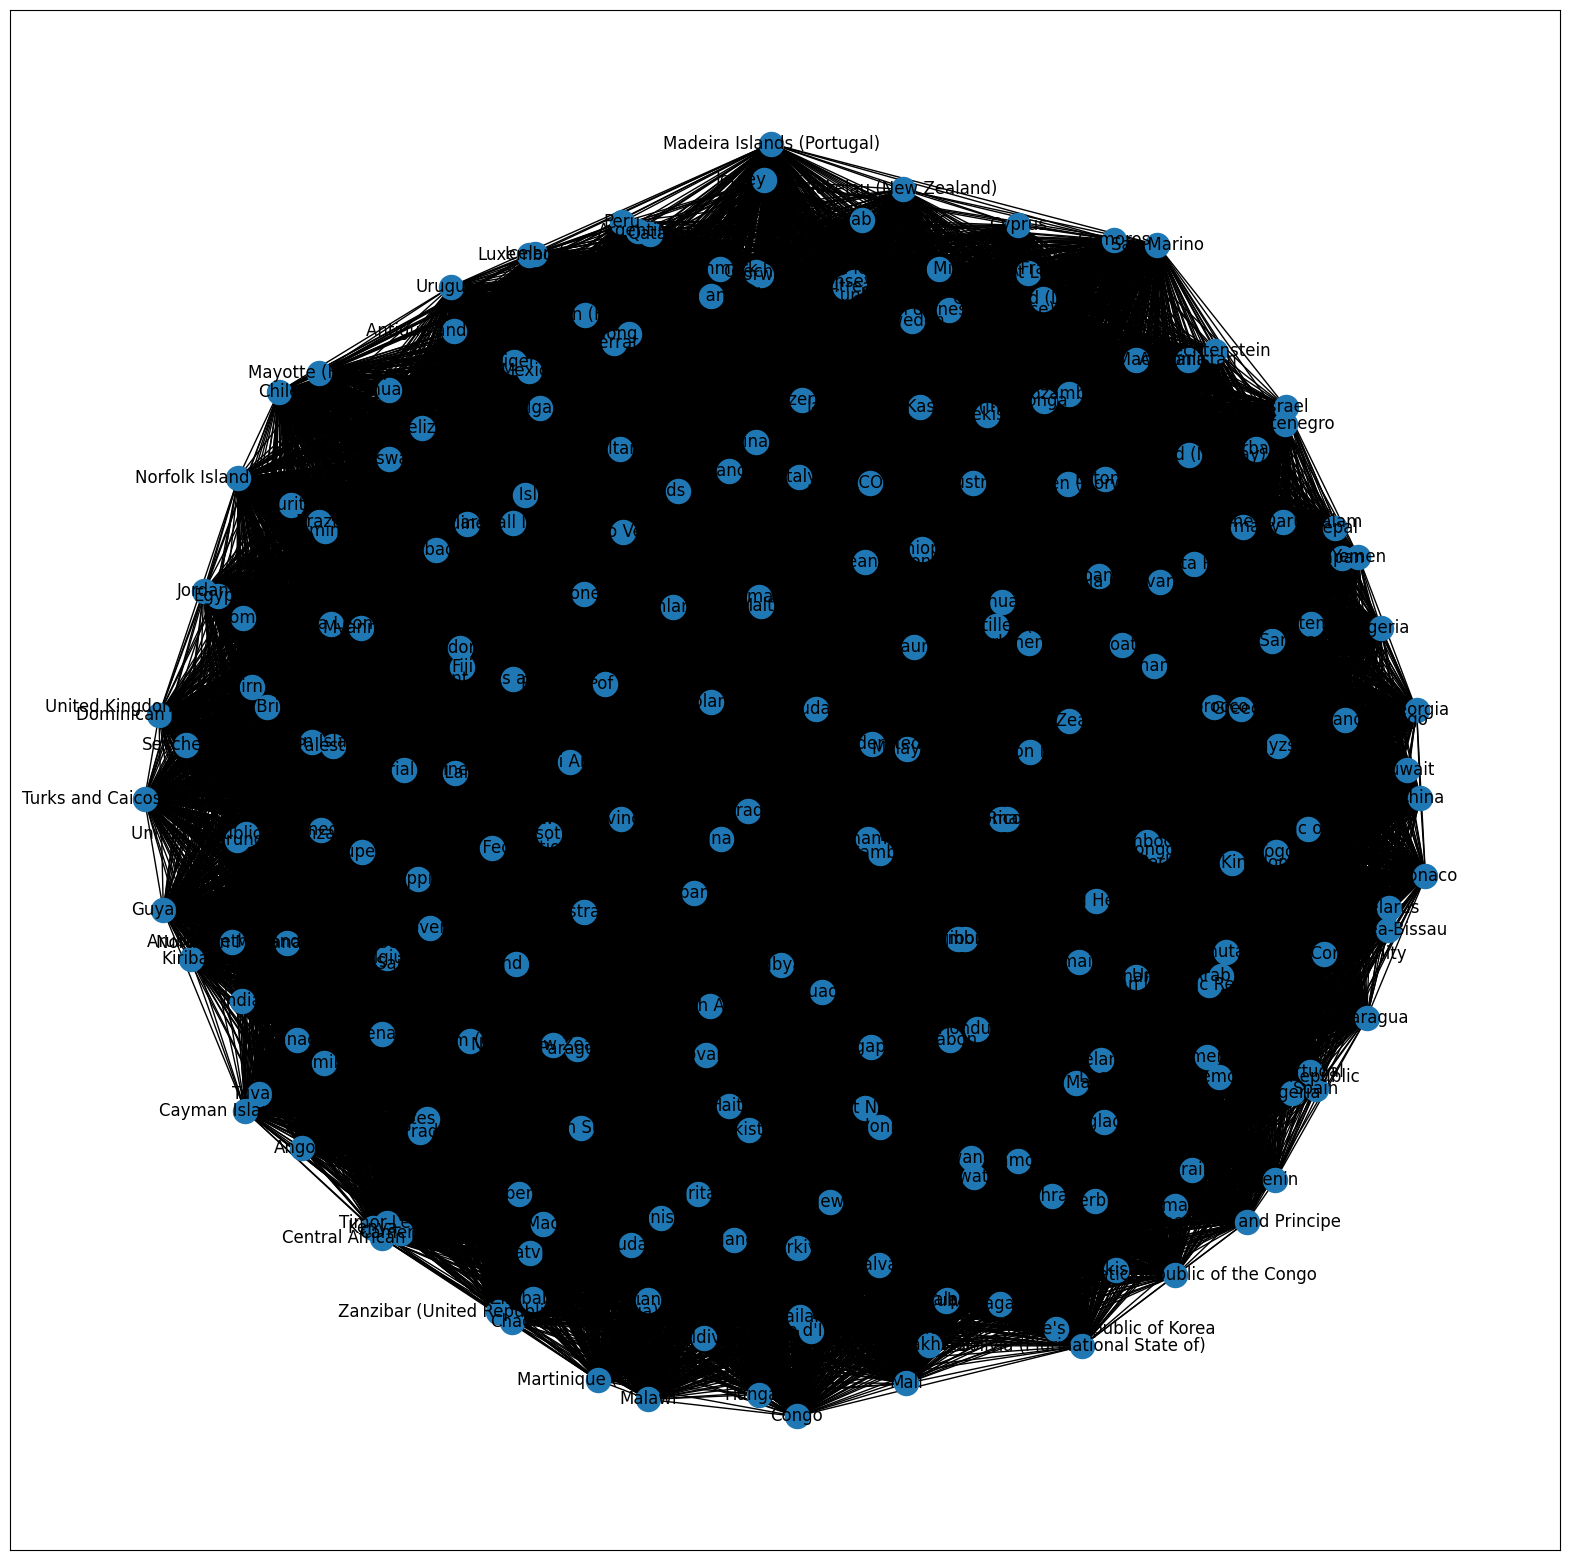

In [29]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt
countries_swap_copy = countries_swap.copy()

G = nx.Graph()

size = country_co_occurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])
# Remove small isalnds
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(20, 20))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [30]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.1,seed=69)
unique_coms = np.unique(list(comms))

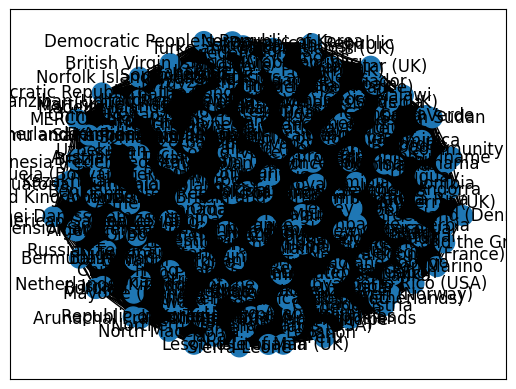

In [31]:
community_assignment = {}

# Assign community indices to nodes


# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [32]:
from networkx.algorithms.community import louvain_communities
resolution=[0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
scores=np.zeros(len(resolution))
j=0
for res in resolution:
    comms = louvain_communities(G,weight="weight",resolution=res,seed=69)
    unique_coms = np.unique(list(comms))
    i=1
    communities={}
    for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1
    for com in communities.values():
        if len(com)==1:
            scores[j]+=1
        elif len(com)>=30:
            scores[j]+=len(com)-29
    j+=1

In [33]:
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[res_op],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1



for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

c 1
Palestine
Sudan
Jordan
Somalia
c 2
Kyrgyzstan
Lithuania
Tajikistan
Azerbaijan
Turkmenistan
Kazakhstan
Belarus
Hungary
Ukraine
Georgia
Republic of Moldova
Armenia
Romania
Mongolia
Russian Federation
Uzbekistan
c 3
Isle of Man (UK)
c 4
Djibouti
Democratic Republic of the Congo
Albania
Algeria
Chad
Senegal
Madagascar
Gabon
Rwanda
Mali
Central African Republic
Benin
Guinea
Cameroon
Angola
Mauritania
Togo
Haiti
Congo
Niger
Côte d'Ivoire
Cambodia
Burkina Faso
Burundi
c 5
Dominica
Barbados
Mauritius
Norfolk Island (Australia)
Bermuda (UK)
Tonga
Cayman Islands (UK)
Belize
Trinidad and Tobago
Guam (USA)
Bahamas
American Samoa (USA)
Saint Helena, Ascension and Tristan da Cunha (UK)
Antigua and Barbuda
Montserrat (UK)
Jamaica
c 6
Viet Nam
Philippines
Japan
Indonesia
Republic of Korea
c 7
Lesotho
United Republic of Tanzania
Kenya
Eswatini
Namibia
Zambia
Uganda
Malawi
Botswana
Ethiopia
Zimbabwe
c 8
Zanzibar (United Republic of Tanzania)
c 9
Cabo Verde
Timor-Leste
Guinea-Bissau
Mozambique
Brazil

In [34]:
# compute similartiy between countries:
#WIP
c1 = ["Pakistan","India"]
print(country_topic_matrix[countries["Pakistan"],:])
print(country_topic_matrix[countries["India"],:])
print(country_co_occurrence[countries["Pakistan"],countries["India"]])
for i in range(250):
    if country_co_occurrence[countries["Pakistan"],i] >=0.3:
        print(i,country_co_occurrence[countries["Pakistan"],i])

[7. 1. 3. ... 0. 0. 0.]
[15.  0.  6. ...  0.  0.  0.]
0.5122603233793503
0 0.4087179722613619
1 0.43510671007224594
2 0.46421566835627603
3 0.4761154108436724
4 0.45530223969972416
5 0.4230038144322913
6 0.4392286935064427
7 0.4199970325274947
9 0.402339676889427
10 0.46044395407570504
11 0.4063204346894048
12 0.4980955503836681
13 0.4487753185145595
14 0.4603852351995171
15 0.4543909462400662
16 0.44698440843672693
17 0.43938422395265986
18 0.4293198313971791
19 0.4514064799870706
20 0.42003594304029823
21 0.4363485142519641
22 0.4561646440881185
23 0.4123812858516074
24 0.434963415185215
25 1.0
26 0.381279747268163
27 0.4057664991230827
28 0.4373660439406508
29 0.44403244671162423
30 0.4356903330845324
31 0.4629934117334357
34 0.4378165188967772
36 0.4358786054097127
37 0.43729759317564154
38 0.5072740584785208
39 0.4837577673729535
40 0.45190037016653545
41 0.45515477831098855
42 0.47248343169841023
43 0.3883057989933616
45 0.3999960266931174
46 0.3905716895793128
47 0.4601933453445

In [35]:
countries_swap[249]

'Bhutan'

## Compare communities to income

In [36]:
import pandas as pd
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [37]:

income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])


In [38]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

C:\Users\Jacob pc\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Match: United States of America - United States
Match: Wallis and Futuna Islands (France) - France
Match: French Guiana (France) - France
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Yemen - Yemen, Rep.
Match: Aruba (Netherlands) - Aruba
Match: Gibraltar (UK) - Gibraltar
Match: Tromelin Island (France) - France
Match: South Georgia and the South Sandwich Islands (UK) - Georgia
Match: Netherlands (Kingdom of the) - Netherlands
Match: Viet Nam - Vietnam
Match: Serbia and Montenegro - Montenegro
Match: American Samoa (USA) - American Samoa
Match: Faroe Islands (Denmark) - Denmark
Match: Egypt - Egypt, Arab Rep.
Match: Turks and Caicos Islands (UK) - Turks and Caicos Islands
Match: United States Virgin Islands - United States
Match: Sint Maarten (Netherlands) - Netherlands
Match: French Polynesia (France) - France
Match: Greenland (Denmark) - Denmark
Match: Puerto Rico (USA) - Puerto Rico
Match: Svalbard (Norway) - Norway
Match: Andaman and Nicobar Is

In [39]:

for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [40]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',1),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]


for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [41]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std
    

    

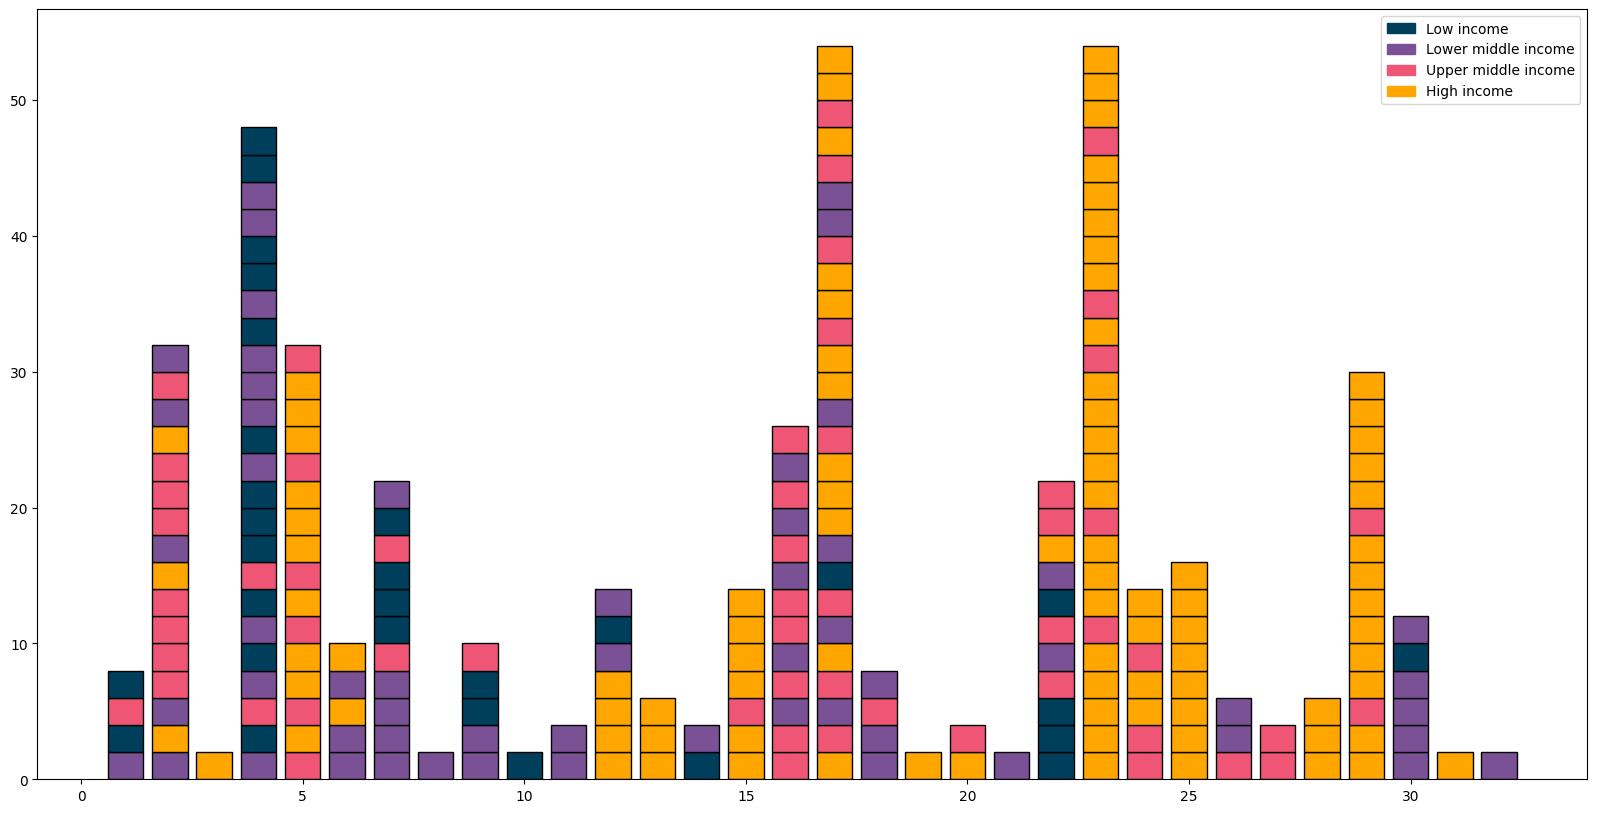

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            h=2
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])



In [43]:
for c in communities[32]:
    print(countries_swap[c],countries_income_dic[c])

Sri Lanka 1


In [44]:
print("Number of countries in different income groups + proportion")
print("Low: ",income_groups.count("Low income"),income_groups.count("Low income")/len(income_groups))
low_p = income_groups.count("Low income")/len(income_groups)
print("Lower middle: ",income_groups.count("Lower middle income"),income_groups.count("Lower middle income")/len(income_groups))
lowermiddle_p = income_groups.count("Lower middle income")/len(income_groups)
print("Upper middle: ",income_groups.count("Upper middle income"),income_groups.count("Upper middle income")/len(income_groups))
uppermiddle_p = income_groups.count("Upper middle income")/len(income_groups)
print("High: ",income_groups.count("High income"),income_groups.count("High income")/len(income_groups))
high_p = income_groups.count("High income")/len(income_groups)

Number of countries in different income groups + proportion
Low:  28 0.10566037735849057
Lower middle:  54 0.2037735849056604
Upper middle:  54 0.2037735849056604
High:  81 0.30566037735849055


In [45]:
# Make permutation test
observed_income =[]
observed_community = []
for i in range(len(communities)):
     for c in communities[i+1]:
        observed_income.append(countries_income_dic[c])
        observed_community.append(i+1)
# Dsitribtuion prior to permutation (proportion of high income)
def count_community_3(communities, numbers):
    count_array = np.zeros(len(communities))  # Dictionary to store the count of each community
    community_count = np.zeros(len(communities))
    # Iterate over the communities and numbers lists
    for community, number in zip(communities, numbers):
        if number == 3:
            count_array[community-1]+=1
        community_count[community-1]+=1
    return count_array,community_count

og_scores = []
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    og_scores.append(count/total_count)




In [46]:
import random
permuted_scores=[]
prop_high,community_count=count_community_3(observed_community,observed_income)
for community, count, total_count in zip(communities,prop_high,community_count):
    #print(f"Community {community} has {count/total_count} % of high income.")
    permuted_scores.append(count/total_count)




In [47]:
a=observed_community
a

[1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 9,
 9,
 9,
 9,
 9,
 10,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 19,
 20,
 20,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 27,
 27,
 28,
 28,
 28,
 29,
 29,
 29

# Governance

In [48]:
#country governance data
governance = pd.read_excel("governence data update.xlsx")
print(governance.keys())
governance_country = []
categorized_governance = []

for est,c in zip(governance["Estimate"],governance["Country/Territory"]):
    if est >=1:
        categorized_governance.append(3)
        governance_country.append(c)
    elif est>=0 and est<1:
        categorized_governance.append(2)
        governance_country.append(c)
    elif est>-1 and est<0:
        categorized_governance.append(1)
        governance_country.append(c)
    elif est<=-1:
        categorized_governance.append(0)
        governance_country.append(c)
        

Index(['Country/Territory', 'Estimate'], dtype='object')


In [49]:
#income_countries = list(income["Economy"])
#income_groups = list(income["Income group"])
governance_listed_countries =[]
governance_dic={}
for i in range(len(governance_country)):
    for j in range(len(countries_swap)):
        if governance_country[i] == countries_swap[j]:
            governance_listed_countries.append(j)
            governance_dic[j]=categorized_governance[i]
missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_listed_countries:
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [50]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_gov_countries_names:
    best_match = process.extractOne(country1, governance_country)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Match: United States of America - United States
Match: Wallis and Futuna Islands (France) - France
Match: French Guiana (France) - France
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Yemen - Yemen, Rep.
Match: Aruba (Netherlands) - Aruba
Match: Tromelin Island (France) - France
Match: South Georgia and the South Sandwich Islands (UK) - Georgia
Match: Netherlands (Kingdom of the) - Netherlands
Match: Viet Nam - Vietnam
Match: Serbia and Montenegro - Montenegro
Match: American Samoa (USA) - American Samoa
Match: Faroe Islands (Denmark) - Denmark
Match: Egypt - Egypt, Arab Rep.
Match: United States Virgin Islands - United States
Match: Sint Maarten (Netherlands) - Netherlands
Match: French Polynesia (France) - France
Match: Greenland (Denmark) - Denmark
Match: Puerto Rico (USA) - Puerto Rico
Match: Svalbard (Norway) - Norway
Match: Andaman and Nicobar Islands (India) - India
Match: Juan de Nova Island (France) - France
Match: Arunachal Pradesh (India

In [51]:
for i,j in matches:
    governance_dic[countries[i]]=categorized_governance[governance_country.index(j)]

missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_dic.keys():
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [52]:
# Extra countries, 5 = Nan
extra_countries = [('Saint Barthélemy (FRA)',5),("Isle of Man (UK)",5),('Kyrgyzstan',1),('Andean Community',5),('Palestine',0),('Iran (Islamic Republic of)',0),('Slovakia',2),("Curaçao",5),('Saint Helena, Ascension and Tristan da Cunha (UK)',5),('Jersey  (UK)',3),('Montserrat (UK)',3),("Bermuda (UK)",5),("Cabo Verde",5),('European Union',5),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',5),
('Anguilla (UK)',5),('Cook Islands',3),('Micronesia (Federated States of)',3),('Republic of Korea',2),("Northern Mariana Islands (USA)",3),('MERCOSUR',5),("British Virgin Islands (UK)",5),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',0),('Pitcairn (UK)',3),("Lao People's Democratic Republic",0),("Turks and Caicos Islands (UK)",5),("Gibraltar (UK)",5),
("Taiwan Province of China",3),("South Georgia and the South Sandwich Islands (UK)",5)]


for i,j in extra_countries:
    governance_dic[countries[i]]= j


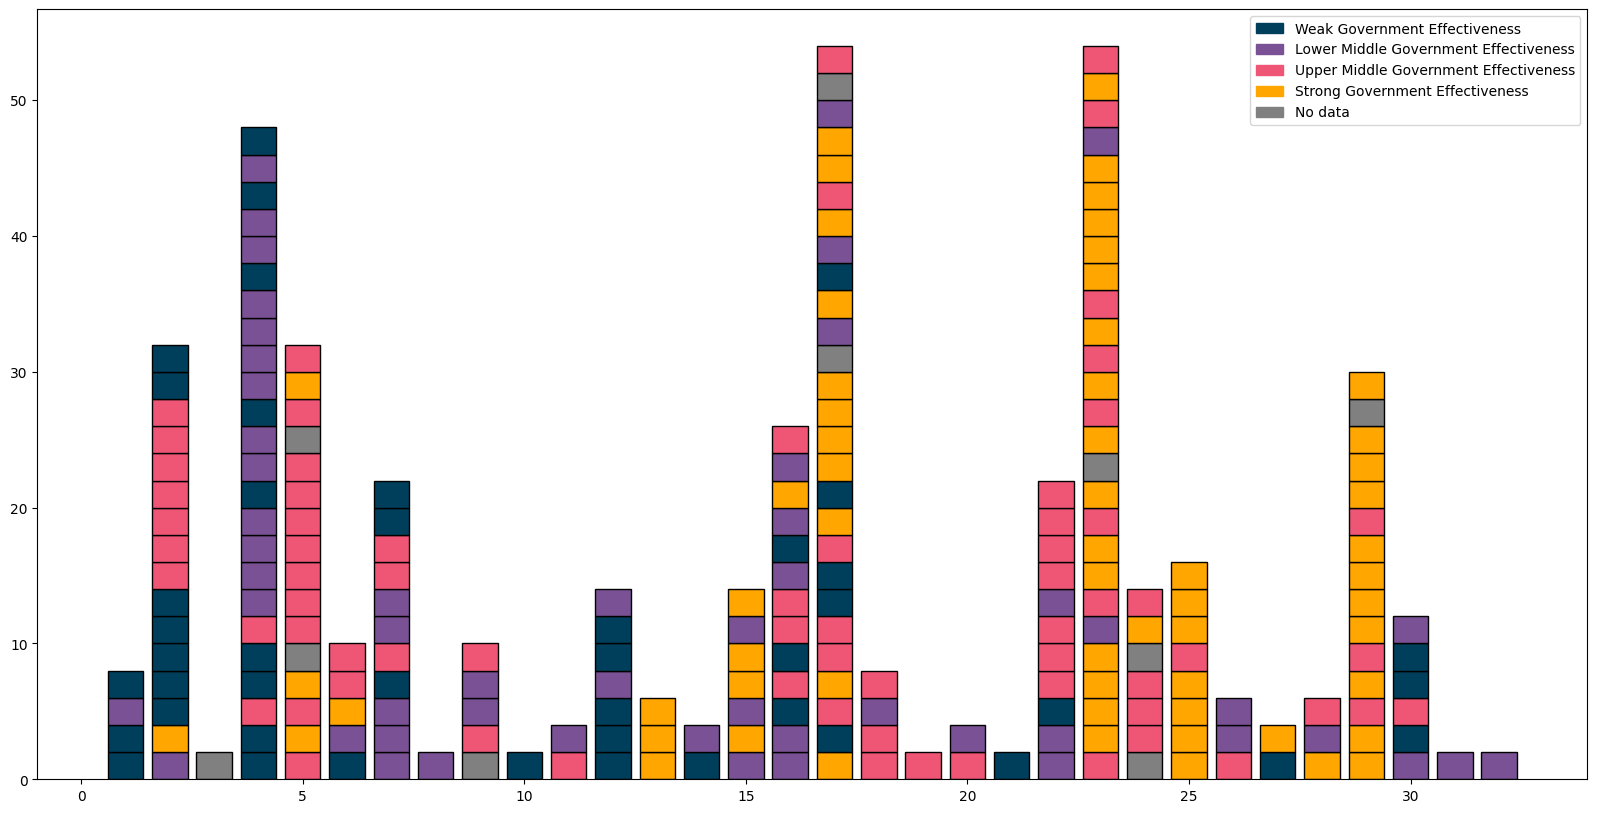

In [53]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, color="#808080",width=0.8,edgecolor="#000000")
            h=2
        else:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 2, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Weak Government Effectiveness")
pop_b = mpatches.Patch(color='#7a5195', label="Lower Middle Government Effectiveness")
pop_c = mpatches.Patch(color='#ef5675', label="Upper Middle Government Effectiveness")
pop_d = mpatches.Patch(color='#ffa600', label='Strong Government Effectiveness')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])

In [54]:
print("Number of countries in different government effectiveness classes + proportion")
low_p = list(governance_dic.values()).count(0)/len(income_groups)
print("Low: ",list(governance_dic.values()).count(0),low_p)
lowermiddle_p = list(governance_dic.values()).count(1)/len(income_groups)
print("Lower middle: ",list(governance_dic.values()).count(1),lowermiddle_p)
uppermiddle_p = list(governance_dic.values()).count(2)/len(income_groups)
print("Upper middle: ",list(governance_dic.values()).count(2),uppermiddle_p)
high_p = list(governance_dic.values()).count(3)/len(income_groups)
print("High: ",list(governance_dic.values()).count(3),high_p)


Number of countries in different government effectiveness classes + proportion
Low:  44 0.1660377358490566
Lower middle:  54 0.2037735849056604
Upper middle:  72 0.27169811320754716
High:  72 0.27169811320754716


In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

#combine the data points
data_points_dic = {}

for i in governance_dic:
    data_points_dic[i] = [governance_dic[i], countries_income_dic[i]]

lda = LinearDiscriminantAnalysis()

c_assign = []
for i in range(500):
    if i in community_assignment:
        c_assign.append(community_assignment[i])

X = []
for i in range(500):
    if i in data_points_dic:
        X.append(data_points_dic[i])

X2 = []
for i in range(500):
    if i in community_assignment:
        X2.append(X[i])

X2 = np.array(X2)
c_assign = np.array(c_assign)



In [56]:
lda.fit(X2,c_assign)
predicts = lda.predict(X2)
accuracy = accuracy_score(c_assign,predicts)
print("Accuracy:", accuracy)



Accuracy: 0.23628691983122363


In [57]:
XX = []
for i in range(500):
    if i in countries_income_dic:
        XX.append(countries_income_dic[i])


XX2 = []
for i in range(500):
    if i in community_assignment:
        XX2.append(XX[i])


In [58]:
XXX = []
for i in range(500):
    if i in countries_income_dic:
        XXX.append(governance_dic[i])


XXX3 = []
for i in range(500):
    if i in community_assignment:
        XXX3.append(XXX[i])

In [63]:
from sklearn.metrics import mutual_info_score
mi = mutual_info_score(XXX3,c_assign)
print(mi)

0.5679606183231087
